In [50]:
import tensorflow as tf
import keras
import os

## Create label dictionary
Since the price buckets may change, we'll create a dictionary to map the price buckets to a prettier format

In [51]:
# Get the buckets based on sub-folders of `buckets`
buckets = [f for f in os.listdir('buckets') if os.path.isdir(os.path.join('buckets', f))]

# Create a dictionary of classes where the key is the class name and the value is a formatted string of the class name
classes = {bucket: '$' + bucket.replace('_', '-$').title() for bucket in buckets}
# Make a label dict of the clases sorted by key, with the values
label_dict = [v for k, v in sorted(classes.items(), key=lambda item: item[0])]
label_dict

['$10-$15',
 '$15-$20',
 '$20-$25',
 '$25-$30',
 '$30-$35',
 '$35-$40',
 '$40-$45',
 '$45-$50']

## Getting the data
We'll start by loading the data from the `buckets` folder

In [52]:
image_dim = 256

In [53]:
price_data = keras.utils.image_dataset_from_directory("buckets", labels="inferred", image_size=(image_dim,image_dim), batch_size=None)
price_data.cardinality()

Found 356 files belonging to 8 classes.


<tf.Tensor: shape=(), dtype=int64, numpy=356>

In [54]:
price_data.shuffle(price_data.cardinality())
test_prices = price_data.take(100) 
train_prices = price_data.skip(100)
test_prices = test_prices.take(200)
val_prices = train_prices.skip(200)

test_prices.cardinality(), val_prices.cardinality(), train_prices.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=100>,
 <tf.Tensor: shape=(), dtype=int64, numpy=56>,
 <tf.Tensor: shape=(), dtype=int64, numpy=256>)

In [55]:
#reshape images (not necessary with this dataset, but you might enjoy this code for the future)
size = (image_dim, image_dim)
train_ds = train_prices.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = val_prices.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_prices.map(lambda x, y: (tf.image.resize(x, size), y))

In [56]:
## We'll also setup prefetching so that we can more easily load the data for training/testing
batch_size = 16
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Building the model
In the first line we'll load the Xception model trained on Imagenet data. However we'll explicity drop the fully connected layers so we can add our own (seen in the `include_top=False` line)

In [57]:
# From Keras we load the Xception model
base_model = keras.applications.Xception(
    weights="imagenet",  # load the model with weights from training on ImageNet
    input_shape=(image_dim, image_dim, 3), 
    include_top=False, # This states we won't include the "top" layers (the classifier)
)

# We can freeze the weights of any model/layer so they won't be updated when training the model
base_model.trainable = False

# With the base model defined we can create a regular Keras sequential model
inputs = keras.Input(shape=(image_dim, image_dim, 3))
# This version of the Xception model expects inputs to be scaled from (0, 255) to a range of (-1., +1.)
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers, by setting training=False here it'll prevent those from being modified
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()
train_ds, validation_ds

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 128)               262272    
                                                           

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [58]:
model.compile(
    optimizer=keras.optimizers.legacy.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

16/16 [==============================] - 7s 272ms/step - loss: -1.7010 - binary_accuracy: 0.3008 - val_loss: -2.2641 - val_binary_accuracy: 0.3571


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.take_op._TakeDataset'>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
1/1 [==============================] - 1s 1s/step


/var/folders/l4/p__14z5x5rl4rjxvfwyqm1z00000gn/T/ipykernel_1848/1346736168.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Actual: {label_dict[int(labels[iy])]}\nPredicted: {label_dict[int(model_labels[iy])]}")


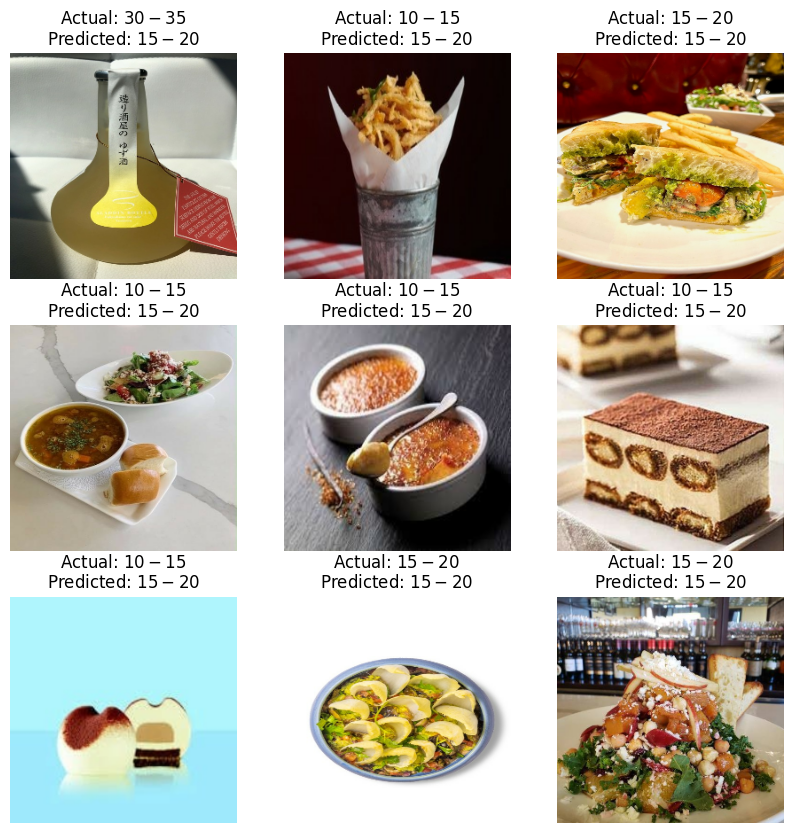

In [59]:
import matplotlib.pyplot as plt
import numpy as np

print(type(test_ds))
print(type(test_ds.take(1)))
print(test_ds)

plt.figure(figsize=(10, 10))
for ix, (images, labels) in enumerate(train_ds.take(1)):
    model_preds = model.predict(images)
    model_labels = np.where(model_preds>0, 1, 0)
    for iy in range(9):
        ax = plt.subplot(3, 3, iy + 1)
        plt.imshow(np.array(images[iy]).astype(int))
        plt.title(f"Actual: {label_dict[int(labels[iy])]}\nPredicted: {label_dict[int(model_labels[iy])]}")
        plt.axis("off")